In [1]:
import pandas as pd
import os
from datetime import datetime as dt
import wrangle
import re
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pprint
plt.rcParams["figure.figsize"] = (12,10)
alpha =.05

### Acquire

In [2]:
df = wrangle.get_combined_df()
df.head(1)

,ercot_load,dow,is_weekday,is_obs_holiday,hs_temp,hs_feelslike,hs_dew,hs_humidity,hs_precip,hs_windgust,...,vc_precip,vc_windgust,vc_windspeed,vc_winddir,vc_sealevelpressure,vc_cloudcover,vc_visibility,vc_solarradiation,vc_solarenergy,vc_uvindex
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00-06:00,7931.2419,Friday,1,1,47.3,41.2,43.2,85.37,0.0,27.5,...,0.0,24.2,16.1,360.0,1027.7,98.7,9.9,0.0,NaN,0


### Prepare

In [3]:
df['hour'] = df.index.strftime('%H')

train = df[:'2017']
test = df['2018':]

In [4]:
def subgroups():
    weekday = train[train.is_weekday== 1]
    weekend = train[train.is_weekday== 0]
    saturday = train[train.dow=='Saturday']
    sunday = train[train.dow=='Sunday']
    holidays = train[train.is_obs_holiday==1]
    not_holiday = train[train.is_obs_holiday==0]
    return weekday, weekend, saturday, sunday, holidays, not_holiday

In [5]:
weekday, weekend, saturday, sunday, holidays, not_holiday = subgroups()

In [6]:
def ercot_load_by_hour():
    zero = train[train.hour=='00'].ercot_load
    one = train[train.hour=='01'].ercot_load
    two = train[train.hour=='02'].ercot_load
    three = train[train.hour=='03'].ercot_load
    four = train[train.hour=='04'].ercot_load
    five = train[train.hour=='05'].ercot_load
    six = train[train.hour=='06'].ercot_load
    seven = train[train.hour=='07'].ercot_load
    eight = train[train.hour=='08'].ercot_load
    nine = train[train.hour=='09'].ercot_load
    ten = train[train.hour=='10'].ercot_load
    eleven = train[train.hour=='11'].ercot_load
    tweleve = train[train.hour=='12'].ercot_load
    thirteen = train[train.hour=='13'].ercot_load
    fourteen = train[train.hour=='14'].ercot_load
    fifteen = train[train.hour=='15'].ercot_load
    sixteen = train[train.hour=='16'].ercot_load
    seventeen = train[train.hour=='17'].ercot_load
    eighteen = train[train.hour=='18'].ercot_load
    nineteen = train[train.hour=='19'].ercot_load
    twenty = train[train.hour=='20'].ercot_load
    twentyone = train[train.hour=='21'].ercot_load
    twentytwo = train[train.hour=='22'].ercot_load
    twentythree = train[train.hour=='23'].ercot_load
    return zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, tweleve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree
zero, one, two, three, four, five, six, seven, eight, nine, ten, eleven, tweleve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty, twentyone, twentytwo, twentythree = ercot_load_by_hour() 

In [7]:
def days_of_week():
    monday = train[train.dow=='Monday'].ercot_load
    tuesday = train[train.dow=='Tuesday'].ercot_load
    wednesday = train[train.dow=='Wednesday'].ercot_load
    thursday = train[train.dow=='Thursday'].ercot_load
    friday = train[train.dow=='Friday'].ercot_load
    saturday = train[train.dow=='Saturday'].ercot_load
    sunday = train[train.dow=='Sunday'].ercot_load
    return monday, tuesday, wednesday, thursday, friday, saturday, sunday

monday, tuesday, wednesday, thursday, friday, saturday, sunday = days_of_week()

### Explore

In [8]:
def plot_ercot_resample():
    train.resample('H').ercot_load.mean().plot(alpha=.5, label='Hourly')
    train.resample('D').ercot_load.mean().plot(alpha=.5, label='Daily')
    train.resample('W').ercot_load.mean().plot(alpha=.8, label='Weekly')
    train.resample('M').ercot_load.mean().plot(label='Montly')
    train.resample('Y').ercot_load.mean().plot(label='Yearly')
    plt.legend()
    plt.show()

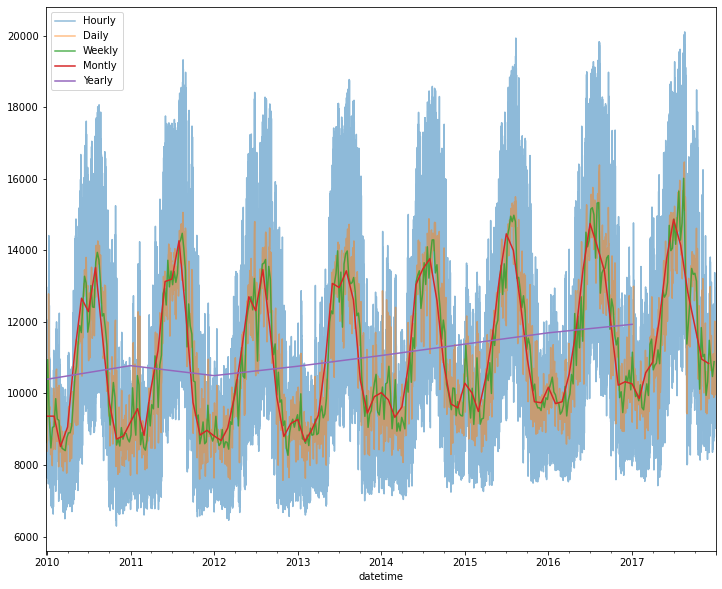

In [9]:
plot_ercot_resample()

**Notes:** Seasonality is visible, with an increase in ercot load over time.

In [10]:
def plot_hourly_ercot_load():
    plt.figure(figsize=(28, 24))
    order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    sns.boxplot(x = 'dow', y = 'ercot_load', data=train, hue='hour',order=order) 
    plt.title('Ercot Load by Time of Day on each Weekday', fontsize=20)
    plt.axhline(train.ercot_load.median(),ls= ':', color = 'red', linewidth=2)
    plt.show()

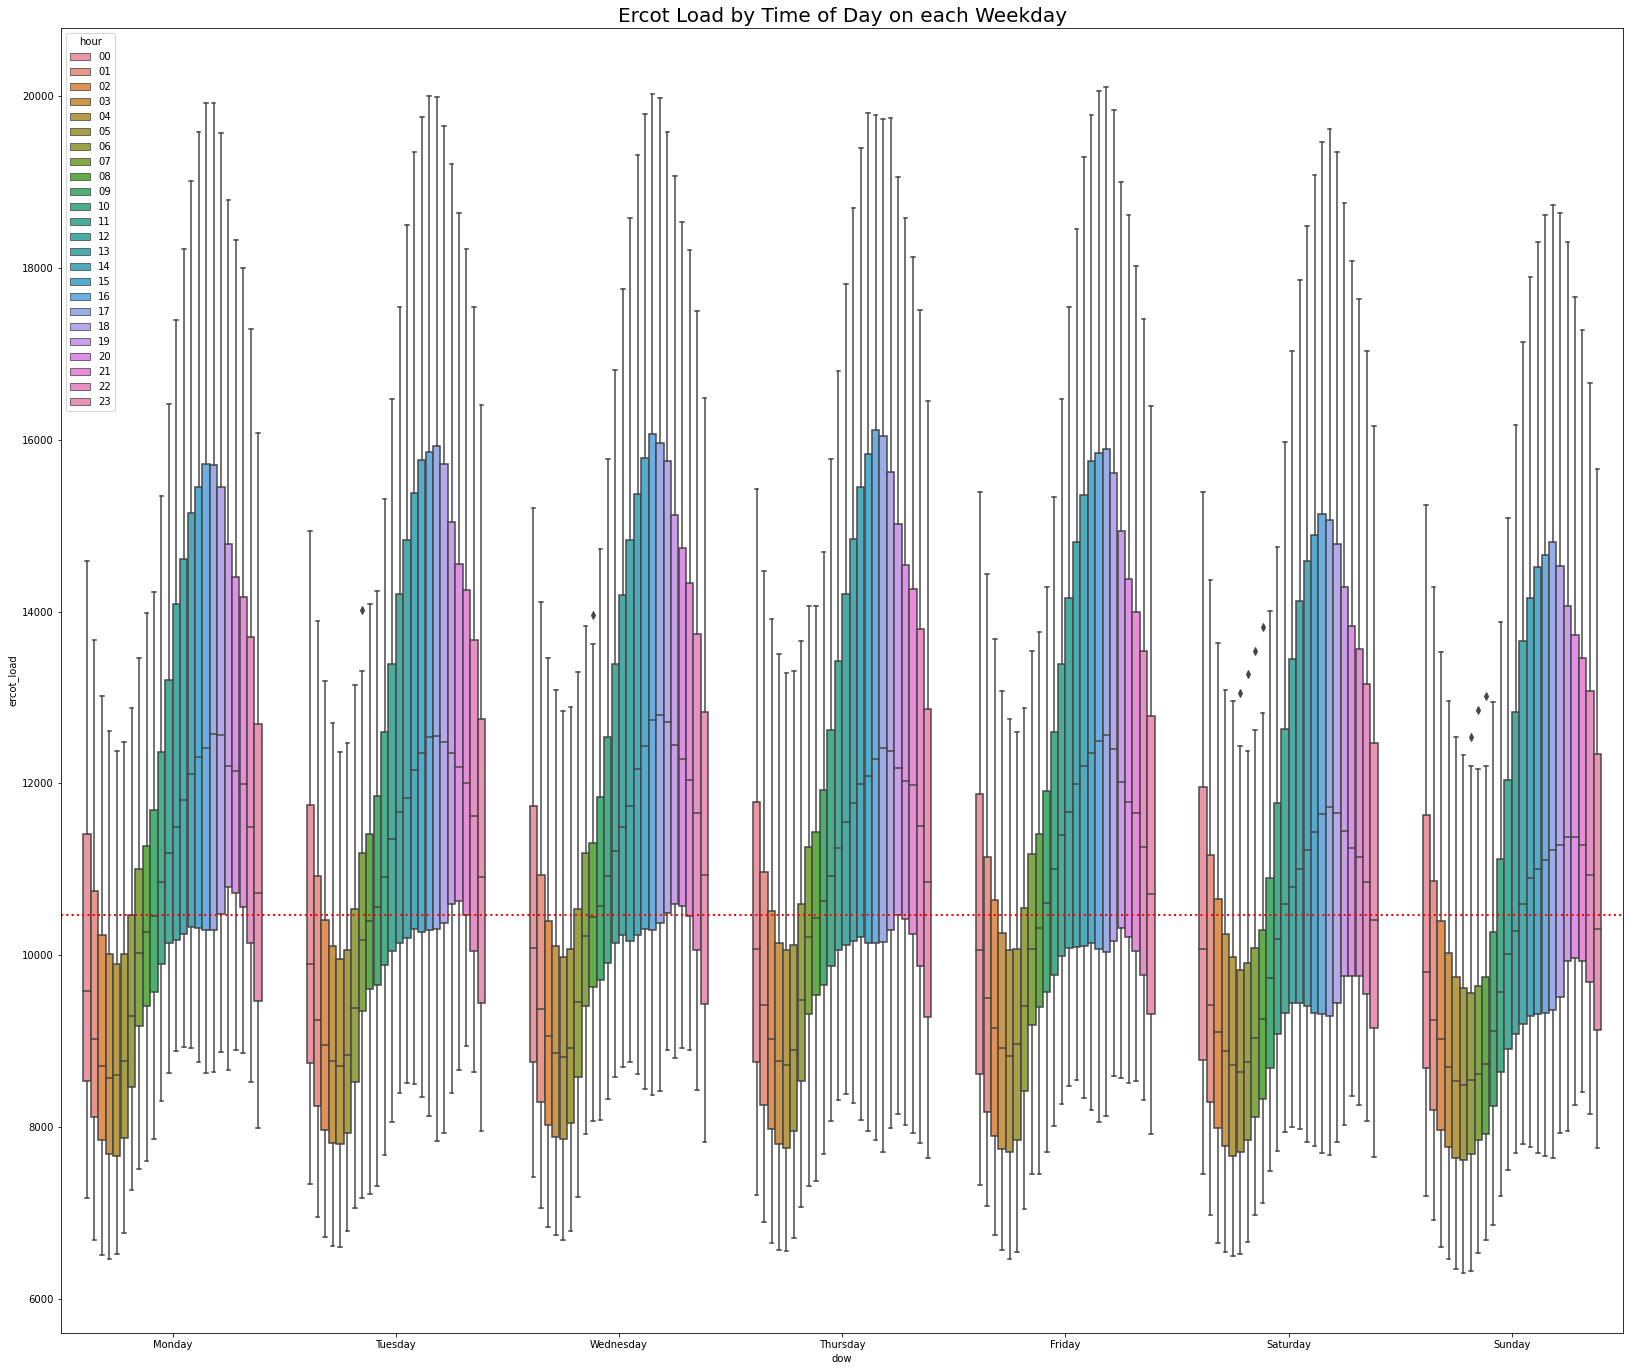

In [11]:
plot_hourly_ercot_load()

**Notes:** 
- There is a visible change in ercot load by hour, with a lull in the early hours of the day and an expected increase in afternoon.
- Wekkdays utilize more energy than Saturday and Sunday.

### Hypothesis Testing

#### Perform Levene's Test to check for equal variance.
- Null Hypothesis: Variance is equal between weekdays and weekends.
- Alternative Hypothesis: Variance is not equal between weekdays and weekends.

In [12]:
stat, p = stats.levene(weekday.ercot_load, weekend.ercot_load)
p

3.722072198971905e-12

In [13]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


#### Perform 1-tailed T-test to determine  if ERCOT load is significantly more on weekdays than on weekends.
- Null Hypothesis: ERCOT load on the weekdays is <= ercot load on the weekends.
- Alternative Hypothesis: ERCOT load on the weekdays is > ercot load on the weekends.

In [14]:
t, p = stats.ttest_ind(weekday.ercot_load, weekend.ercot_load, equal_var=False)
t, p / 2

(32.53508226695425, 2.1062869378056432e-229)

In [15]:
    if p / 2 > alpha:
        print("We fail to reject the Null Hypothesis")
    elif t < 0:
        print("We fail to reject the Null Hypothesis")
    else:
        print("We reject the Null Hypothesis")

We reject the Null Hypothesis


### ERCOT Load and Weather

In [16]:
train = train.drop(columns=['dow'])
train['mean_temp']=((train['hs_temp'] + train['vc_temp'] + train['pl_temp'] + train['gv_temp'])/4)

In [18]:
train.corrwith(train['ercot_load'],method='spearman').sort_values(ascending=False).head(7)

ercot_load      1.000000
mean_temp       0.743809
hs_temp         0.738962
hs_feelslike    0.737025
pl_temp         0.733707
vc_feelslike    0.733487
vc_temp         0.733164
dtype: float64

### ERCOT Load and Temperature

In [19]:
def plot_temp_ercot():
    sns.scatterplot(data=train, x='mean_temp',y='ercot_load')
    plt.axvline(x=(50),color='black',ls='--')
    plt.axvline(x=(70),color='black',ls='--')
    plt.title("ERCOT Load and Mean Temperature")
    plt.show()

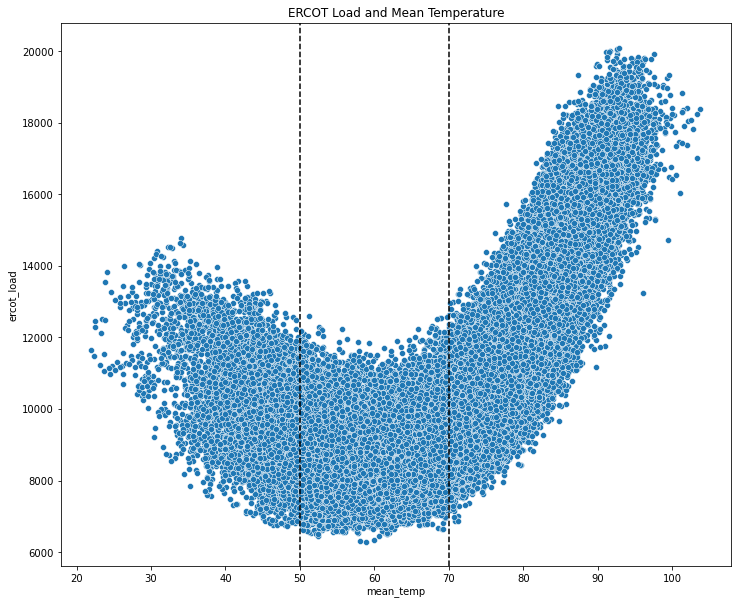

In [20]:
plot_temp_ercot()

In [21]:
def temp_subgroups():
    less_50 = train[train.mean_temp <=50]
    mid_temp = train[(train.mean_temp>50)& (train.mean_temp<70)]
    greater_70 = train[train.mean_temp >=70]
    return less_50, mid_temp, greater_70

less_50, mid_temp, greater_70 = temp_subgroups()

In [25]:
def plot_mean_temp():
    plt.subplot(131)
    g=sns.regplot(data=less_50, x='mean_temp',y='ercot_load',line_kws={'color':'red'})
    plt.title('Less than 50 Degrees')
    g.set_ylim(6000, 22000)

    plt.subplot(132)
    g=sns.regplot(data=mid_temp, x='mean_temp',y='ercot_load',line_kws={'color':'red'})
    plt.title('Between 50 and 70 Degrees')
    g.set_ylim(6000, 22000)
    g.set(yticklabels=[])
    g.set(ylabel=None)

    plt.subplot(133)
    g=sns.regplot(data=greater_70, x='mean_temp',y='ercot_load',line_kws={'color':'red'})
    plt.title('Greater than 70 Degrees')
    g.set_ylim(6000, 22000)
    g.set(yticklabels=[])
    g.set(ylabel=None)
    plt.show()

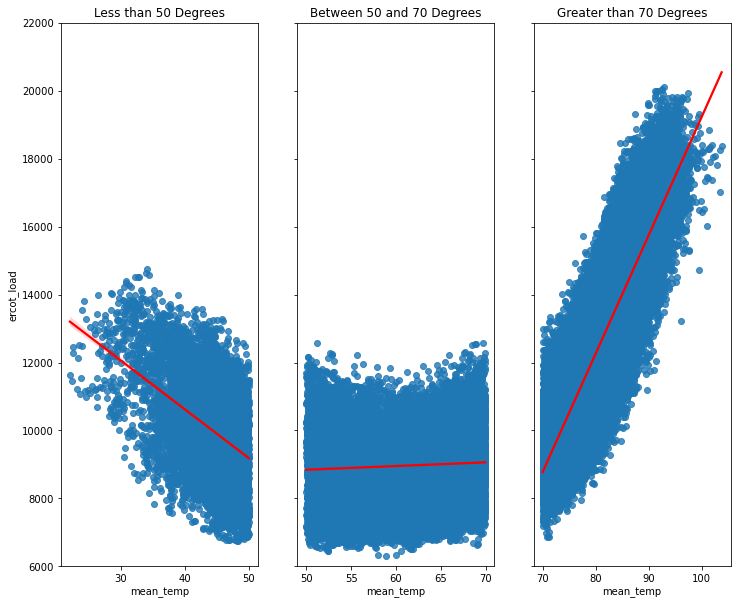

In [27]:
plot_mean_temp()

### Hypothesis Testing

- Null Hypothesis: There is no relationship between ercot load and temperature.
- Alternative Hypothesis: There is a relationship between ercot load and temperature.

In [22]:
r, p = stats.spearmanr(greater_70.ercot_load, greater_70.mean_temp)
r, p

(0.8273795989163407, 0.0)

In [23]:
r, p = stats.spearmanr(mid_temp.ercot_load, mid_temp.mean_temp)
r, p

(0.07272942335979242, 9.462527286479247e-28)

In [24]:
r, p = stats.spearmanr(less_50.ercot_load, less_50.mean_temp)
r, p

(-0.43770741903723387, 3.559188791408997e-287)

**Notes:** We can visually see the relationship between temperature like and ERCOT load, depicted by the U shape. To further test this, we ran Spearman's correlation testing with three different temperature ranges. 

- Less than 50 degrees
- Between 50 and 70 degrees
- Greater than 70 degrees

The strongest relationship between temperature and ERCOT load is when it is greater than 70 degrees with a correlation coefficient of .83. There is a moderate negative relationship between temperatures that are less than 50 degress with a correlation coefficient of -.44. While, the mid-range temperatures are not as strongly correlated, all three ranges of temperatures are related to ERCOT load in regards to statistical significance.